## Import Libraries and Dependencies

In [1]:
# Import our dependencies
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import sklearn as skl
import tensorflow as tf

In [2]:
# Load the data
file_path = Path("resources/processed_stroke_db_w_cat.csv")
df = pd.read_csv(file_path, index_col=[0])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [3]:
df.shape

(4909, 11)

One-hot Encoding for Categotical Data & StandScaler for Numerical Data

In [4]:
# Generate our categorical variable list
cat_labels= df.dtypes[df.dtypes == "object"].index.tolist()
print(cat_labels)

# Check the number of unique values in each column
print(df[cat_labels].nunique())

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64


In [5]:
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[cat_labels]))

encode_df.index = df.index

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_labels)
encode_df.head()

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,
9046,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
31112,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
60182,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1665,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
56669,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [6]:
encode_df.shape

(4909, 16)

In [7]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(cat_labels,1)
df.shape

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


(4909, 22)

In [8]:
# Split our preprocessed data into our features and target arrays
y = df["stroke"].values
X = df.drop(["stroke"],1).values

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, stratify=y)

In [10]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape

(3681, 21)

In [11]:
from collections import Counter

# Resample the training data with SMOTE
# from imblearn.over_sampling import SMOTE
# Instantiate the model
# smote = SMOTE(random_state=1)


# Resample the training data with ADASYN
from imblearn.over_sampling import ADASYN
# Instantiate the model
smote = ADASYN(random_state=1)


# Resample the targets
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({0: 3524, 1: 3542})

## Single Neuron / Single Layer Neural Network

### Train, Fit, Evaluate, Predict Model

In [12]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=21))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 22        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
# Fit the model to the training data
fit_model = nn_model.fit(X_resampled, y_resampled, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
221/221 [==============================] - 1s 2ms/step - loss: 0.7138 - accuracy: 0.5079 - val_loss: 0.7468 - val_accuracy: 0.6572
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 0.6784 - accuracy: 0.5872 - val_loss: 0.7172 - val_accuracy: 0.6832
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 0.6449 - accuracy: 0.6618 - val_loss: 0.7089 - val_accuracy: 0.7182
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 0.6141 - accuracy: 0.7053 - val_loss: 0.7030 - val_accuracy: 0.7166
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5880 - accuracy: 0.7431 - val_loss: 0.6670 - val_accuracy: 0.7288
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5680 - accuracy: 0.7590 - val_loss: 0.6437 - val_accuracy: 0.7345
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5516 - accuracy: 0.7655 - val_loss: 0.6331 - val_accuracy: 0.7305

Epoch 58/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4643 - accuracy: 0.7874 - val_loss: 0.4613 - val_accuracy: 0.7606
Epoch 59/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4643 - accuracy: 0.7843 - val_loss: 0.4798 - val_accuracy: 0.7581
Epoch 60/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4644 - accuracy: 0.7853 - val_loss: 0.4798 - val_accuracy: 0.7573
Epoch 61/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4644 - accuracy: 0.7873 - val_loss: 0.4609 - val_accuracy: 0.7606
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4642 - accuracy: 0.7849 - val_loss: 0.4559 - val_accuracy: 0.7630
Epoch 63/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4642 - accuracy: 0.7862 - val_loss: 0.4610 - val_accuracy: 0.7622
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4636 - accuracy: 0.7864 - val_loss: 0.4856 - val_accuracy:

In [15]:
# Create a DataFrame containing training history
nn_history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
nn_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.713844,0.507925,0.746775,0.657166
2,0.678450,0.587178,0.717243,0.683225
3,0.644857,0.661761,0.708856,0.718241
4,0.614085,0.705350,0.703032,0.716612
5,0.588036,0.743136,0.667045,0.728827
...,...,...,...,...
96,0.463053,0.785310,0.464055,0.760586
97,0.462851,0.784461,0.448533,0.766287
98,0.463020,0.784885,0.459308,0.761401
99,0.462937,0.785310,0.476352,0.757329


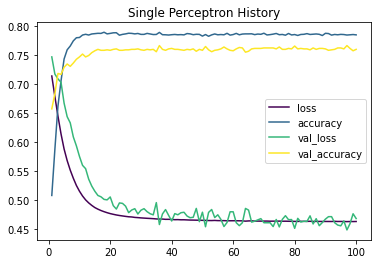

In [16]:
# Plot the history
nn_history_plot = nn_history_df.plot(title = "Single Perceptron History",colormap= "viridis")

<AxesSubplot:>

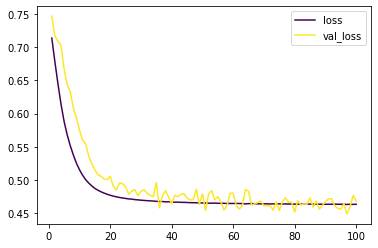

In [17]:
# Plot the loss
nn_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

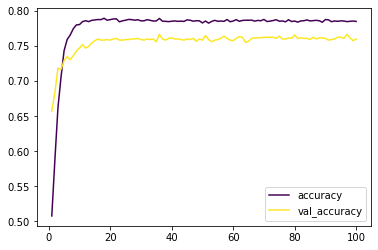

In [18]:
# Plot the accuracy
nn_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [19]:
# Evaluate the model using the test data
nn_model_loss,nn_model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the single perceptron model is: {nn_model_loss}, The accuracy is: {nn_model_accuracy}")

 The loss for the single perceptron model is: 0.46812647581100464, The accuracy is: 0.759772002696991


In [20]:
# Y_pred: flatten & convert prediction probabilities to binary format so it can be passed through confusion matrix
y_pred_nn = nn_model.predict(X_test_scaled)
y_pred_nn = y_pred_nn.flatten()
y_pred_nn_tf=tf.round(y_pred_nn)

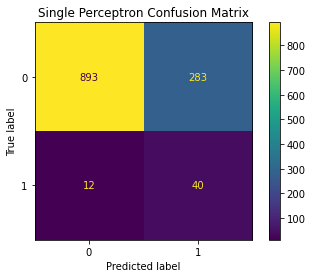

In [21]:
# Display the confusion matrix
nn_cm = confusion_matrix(y_test, y_pred_nn_tf)

nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm)
nn_disp.plot()
nn_disp.ax_.set_title("Single Perceptron Confusion Matrix")
nn_disp

In [49]:
# Advanced Classification Metrics
# Accuracy
nn_accuracy_score = accuracy_score(y_test, y_pred_nn_tf)
print(f'Accuracy Score of the Single Perceptron Model: {nn_accuracy_score}')

# Recall
nn_recall_score = recall_score(y_test, y_pred_nn_tf)
print(f'Recall Score of the Single Perceptron Model: {nn_recall_score}')

# Specificity
nn_specificity_score = 40 / (40+12)
print(f'Specifity Score of the Deep Learning Model: {nn_specificity_score}')

# Balanced Accuracy Score
nn_bas = balanced_accuracy_score(y_test, y_pred_nn_tf)
print(f'Balanced Accuracy Score of the Single Perceptron Model: {nn_bas}')

# Precision
nn_precision_score = precision_score(y_test, y_pred_nn_tf)
print(f'Precision Score of the Single Perceptron Model: {nn_precision_score}')     
   
# F1 Score
nn_f1_score = f1_score(y_test, y_pred_nn_tf)
print(f'F1 Score Score of the Single Perceptron Model: {nn_f1_score}')

# Loss Score
print(f'Loss of the Multiple Perceptron Model: {nn_model_loss}')

# Advanced Classification Metrics DF
nn_acm = {"Model Type": ["Single Perceptron"], "Accuracy":[nn_accuracy_score], "Recall": [nn_recall_score], "Specificity":[nn_specificity_score], 
          "Balanced Accuracy": [nn_bas], "Precision":[nn_precision_score], "F1 Score":[nn_f1_score], "Loss": [nn_model_loss]}
nn_acm_df = pd.DataFrame(data=nn_acm)
nn_acm_df

Accuracy Score of the Single Perceptron Model: 0.759771986970684
Recall Score of the Single Perceptron Model: 0.7692307692307693
Specifity Score of the Deep Learning Model: 0.7692307692307693
Balanced Accuracy Score of the Single Perceptron Model: 0.764292255363684
Precision Score of the Single Perceptron Model: 0.1238390092879257
F1 Score Score of the Single Perceptron Model: 0.21333333333333335
Loss of the Multiple Perceptron Model: 0.46812647581100464


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.759772,0.769231,0.769231,0.764292,0.123839,0.213333,0.468126


## Multiple Neuron Single Layer Neural Network

In [23]:
# Generate our new Sequential model
multi_nn_model = tf.keras.models.Sequential()

# Add the input and hidden layer
number_inputs = 21
number_hidden_nodes = 6

multi_nn_model.add(tf.keras.layers.Dense(units=number_hidden_nodes, activation="relu", input_dim=number_inputs))

# Add the output layer that uses a probability activation function
multi_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [24]:
# Compile the Sequential model together and customize metrics
multi_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
# Fit the model to the training data
fit_model_multi = multi_nn_model.fit(X_resampled, y_resampled, validation_data = (X_test_scaled, y_test), epochs=100, shuffle=True)

Epoch 1/100
221/221 [==============================] - 1s 2ms/step - loss: 0.6643 - accuracy: 0.6568 - val_loss: 0.6656 - val_accuracy: 0.6507
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 0.5351 - accuracy: 0.7386 - val_loss: 0.5256 - val_accuracy: 0.7288
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4941 - accuracy: 0.7714 - val_loss: 0.5010 - val_accuracy: 0.7313
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4701 - accuracy: 0.7891 - val_loss: 0.4719 - val_accuracy: 0.7500
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4553 - accuracy: 0.7948 - val_loss: 0.4634 - val_accuracy: 0.7549
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 0.8010 - val_loss: 0.4437 - val_accuracy: 0.7630
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 0.4384 - accuracy: 0.8019 - val_loss: 0.4551 - val_accuracy: 0.7573

Epoch 58/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3807 - accuracy: 0.8220 - val_loss: 0.4302 - val_accuracy: 0.7663
Epoch 59/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3801 - accuracy: 0.8215 - val_loss: 0.4281 - val_accuracy: 0.7630
Epoch 60/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3797 - accuracy: 0.8242 - val_loss: 0.4216 - val_accuracy: 0.7671
Epoch 61/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3797 - accuracy: 0.8222 - val_loss: 0.4190 - val_accuracy: 0.7671
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3793 - accuracy: 0.8234 - val_loss: 0.4205 - val_accuracy: 0.7663
Epoch 63/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3793 - accuracy: 0.8204 - val_loss: 0.4212 - val_accuracy: 0.7712
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.3788 - accuracy: 0.8228 - val_loss: 0.4252 - val_accuracy:

In [26]:
# Create a DataFrame containing training history
multi_history_df = pd.DataFrame(fit_model_multi.history, index=range(1,len(fit_model_multi.history["loss"])+1))
multi_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.664313,0.656807,0.665551,0.650651
2,0.535088,0.738607,0.525599,0.728827
3,0.494106,0.771441,0.500968,0.731270
4,0.470102,0.789131,0.471857,0.750000
5,0.455253,0.794792,0.463391,0.754886
...,...,...,...,...
96,0.371434,0.827484,0.427906,0.763029
97,0.371081,0.827342,0.438180,0.756515
98,0.370515,0.826776,0.418022,0.776059
99,0.370566,0.828333,0.423151,0.770358


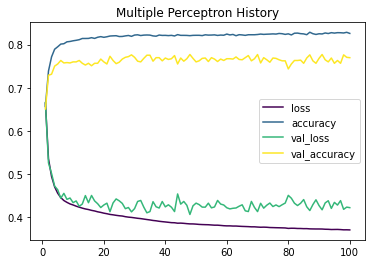

In [27]:
# Plot the history
multi_history_plotf = multi_history_df.plot(title = "Multiple Perceptron History",colormap= "viridis")

<AxesSubplot:>

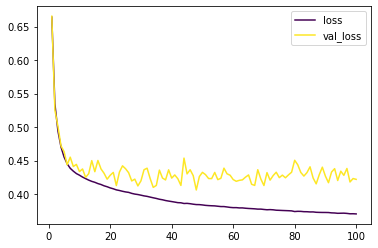

In [28]:
# Plot the loss
multi_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

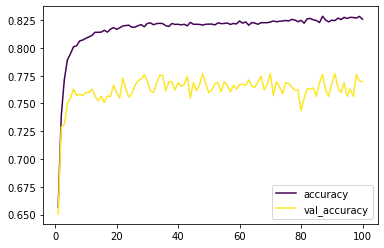

In [29]:
# Plot the accuracy
multi_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [30]:
# Evaluate the model using the test data
multi_model_loss, multi_model_accuracy = multi_nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the multiple perceptron model is: {multi_model_loss}, The accuracy is: {multi_model_accuracy}")

 The loss for the multiple perceptron model is: 0.42191392183303833, The accuracy is: 0.7695439457893372


In [31]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_multi = multi_nn_model.predict(X_test_scaled)
y_pred_multi = y_pred_multi.flatten()
y_pred_multi_tf = tf.round(y_pred_multi)

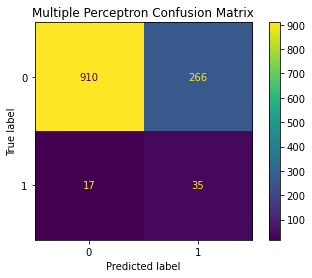

In [32]:
# Display the confusion matrix
multi_nn_cm = confusion_matrix(y_test, y_pred_multi_tf)

multi_disp = ConfusionMatrixDisplay(confusion_matrix=multi_nn_cm)
multi_disp.plot()
multi_disp.ax_.set_title("Multiple Perceptron Confusion Matrix")
multi_disp

In [50]:
# Advanced Classification Metrics
# Accuracy
multi_accuracy_score = accuracy_score(y_test, y_pred_multi_tf)
print(f'Accuracy Score of the Multiple Perceptron Model: {multi_accuracy_score}')

# Recall/ Sensitivity
multi_recall_score = recall_score(y_test, y_pred_multi_tf)
print(f'Recall Score of the Multiple Perceptron Model: {multi_recall_score}')

# Specificity
multi_specificity_score = 35 / (35+17)
print(f'Specifity Score of the Deep Learning Model: {multi_specificity_score}')

# Balanced Accuracy Score
multi_bas = balanced_accuracy_score(y_test, y_pred_multi_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {multi_bas}')

# Precision
multi_precision_score = precision_score(y_test, y_pred_multi_tf)
print(f'Precision Score of the Multiple Perceptron Model: {multi_precision_score}')     
      
# F1 Score
multi_f1_score = f1_score(y_test, y_pred_multi_tf)
print(f'F1 Score Score of the Multiple Perceptron Model: {multi_f1_score}')

# Loss Score
print(f'Loss of the Multiple Perceptron Model: {multi_model_loss}')

# Advanced Classification Metrics DF
multi_acm = {"Model Type": ["Multi Perceptron"], "Accuracy":[multi_accuracy_score], "Recall": [multi_recall_score], "Specificity":[multi_specificity_score], 
          "Balanced Accuracy": [multi_bas], "Precision":[multi_precision_score], "F1 Score":[multi_f1_score], "Loss": [multi_model_loss]}
multi_acm_df = pd.DataFrame(data=multi_acm)
multi_acm_df

Accuracy Score of the Multiple Perceptron Model: 0.7695439739413681
Recall Score of the Multiple Perceptron Model: 0.6730769230769231
Specifity Score of the Deep Learning Model: 0.6730769230769231
Balanced Accuracy Score of the Multiple Perceptron Model: 0.7234432234432235
Precision Score of the Multiple Perceptron Model: 0.11627906976744186
F1 Score Score of the Multiple Perceptron Model: 0.19830028328611896
Loss of the Multiple Perceptron Model: 0.42191392183303833


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Multi Perceptron,0.769544,0.673077,0.673077,0.723443,0.116279,0.1983,0.421914


## Deep Learning Neural Network

In [94]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 50

deep_nn_model = tf.keras.models.Sequential()

# First hidden layer
deep_nn_model.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
deep_nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
deep_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
deep_nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 80)                1760      
                                                                 
 dense_17 (Dense)            (None, 50)                4050      
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 5,861
Trainable params: 5,861
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Compile the model
deep_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [105]:
# Train the model
fit_model_deep = deep_nn_model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1138 - accuracy: 0.9612 - val_loss: 0.1501 - val_accuracy: 0.9577
Epoch 2/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1132 - accuracy: 0.9612 - val_loss: 0.1553 - val_accuracy: 0.9577
Epoch 3/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1113 - accuracy: 0.9625 - val_loss: 0.1618 - val_accuracy: 0.9560
Epoch 4/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1097 - accuracy: 0.9628 - val_loss: 0.1556 - val_accuracy: 0.9544
Epoch 5/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.9614 - val_loss: 0.1591 - val_accuracy: 0.9544
Epoch 6/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1068 - accuracy: 0.9625 - val_loss: 0.1587 - val_accuracy: 0.9560
Epoch 7/100
116/116 [==============================] - 0s 2ms/step - loss: 0.1063 - accuracy: 0.9625 - val_loss: 0.1607 - val_accuracy: 0.9552

Epoch 58/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0588 - accuracy: 0.9777 - val_loss: 0.2533 - val_accuracy: 0.9511
Epoch 59/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0579 - accuracy: 0.9783 - val_loss: 0.2489 - val_accuracy: 0.9438
Epoch 60/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0586 - accuracy: 0.9772 - val_loss: 0.2644 - val_accuracy: 0.9511
Epoch 61/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9777 - val_loss: 0.2536 - val_accuracy: 0.9446
Epoch 62/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0584 - accuracy: 0.9758 - val_loss: 0.2709 - val_accuracy: 0.9446
Epoch 63/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0574 - accuracy: 0.9777 - val_loss: 0.2616 - val_accuracy: 0.9446
Epoch 64/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.9788 - val_loss: 0.2591 - val_accuracy:

In [106]:
# Create a DataFrame containing training history
deep_history_df = pd.DataFrame(fit_model_deep.history, index=range(1,len(fit_model_deep.history["loss"])+1))
deep_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.113844,0.961152,0.150114,0.957655
2,0.113167,0.961152,0.155336,0.957655
3,0.111278,0.962510,0.161773,0.956026
4,0.109669,0.962782,0.155601,0.954397
5,0.109289,0.961424,0.159058,0.954397
...,...,...,...,...
96,0.045476,0.982885,0.315784,0.938111
97,0.042973,0.982070,0.336295,0.942997
98,0.043466,0.983700,0.329041,0.943811
99,0.042244,0.982613,0.325114,0.943811


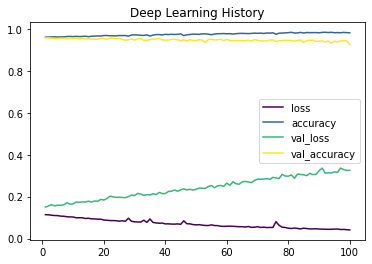

In [107]:
#Plot the history
deep_history_plot = deep_history_df.plot(title = "Deep Learning History",colormap= "viridis")


<AxesSubplot:>

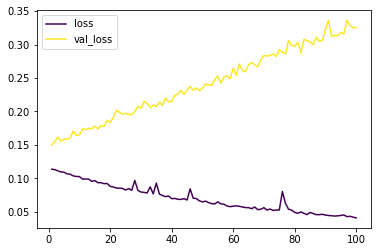

In [108]:
# Plot the loss
deep_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

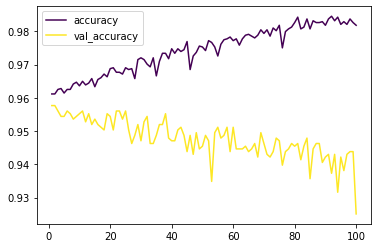

In [109]:
# Plot the accuracy
deep_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [110]:
# Evaluate the model using the test data
dl_model_loss, dl_model_accuracy = deep_nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the deep learning model is: {dl_model_loss}, The accuracy is: {dl_model_accuracy}")

 The loss for the deep learning model is: 0.3255635201931, The accuracy is: 0.9250814318656921


In [111]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_dl = deep_nn_model.predict(X_test_scaled)
y_pred_dl = y_pred_dl.flatten()
y_pred_dl_tf=tf.round(y_pred_dl)

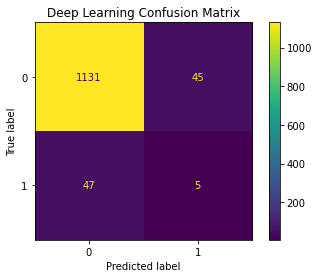

In [112]:
# Display the confusion matrix
dl_nn_cm = confusion_matrix(y_test, y_pred_dl_tf)
dl_disp = ConfusionMatrixDisplay(confusion_matrix=dl_nn_cm)
dl_disp.plot()
dl_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_disp

In [113]:
# Advanced Classification Metrics
# Accuracy
dl_accuracy_score = accuracy_score(y_test, y_pred_dl_tf)
print(f'Accuracy Score of the Deep Learning Model: {dl_accuracy_score}')

## Recall/Sensitivity
dl_recall_score = recall_score(y_test, y_pred_dl_tf)
print(f'Recall Score of the Deep Learning Model: {dl_recall_score}')

# Specificity
dl_specificity_score = 4 / (4+48)
print(f'Specifity Score of the Deep Learning Model: {dl_specificity_score}')

# Balanced Accuracy Score
dl_bas = balanced_accuracy_score(y_test, y_pred_dl_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {dl_bas}')

# Precision
dl_precision_score = precision_score(y_test, y_pred_dl_tf)
print(f'Precision Score of the Deep Learning Model: {dl_precision_score}')     
      
# F1 Score
dl_f1_score = f1_score(y_test, y_pred_dl_tf)
print(f'F1 Score Score of the Deep Learning Model: {dl_f1_score}')

# Loss Score
print(f'Loss of the Deep Learning Model: {dl_model_loss}')

# Advanced Classification Metrics DF
dl_acm = {"Model Type": ["Deep Learning"], "Accuracy":[dl_accuracy_score], "Recall": [dl_recall_score], "Specificity":[dl_specificity_score], 
          "Balanced Accuracy": [dl_bas], "Precision":[dl_precision_score], "F1 Score":[dl_f1_score], "Loss": [dl_model_loss]}
dl_acm_df = pd.DataFrame(data=dl_acm)
dl_acm_df

Accuracy Score of the Deep Learning Model: 0.9250814332247557
Recall Score of the Deep Learning Model: 0.09615384615384616
Specifity Score of the Deep Learning Model: 0.07692307692307693
Balanced Accuracy Score of the Multiple Perceptron Model: 0.5289442700156987
Precision Score of the Deep Learning Model: 0.1
F1 Score Score of the Deep Learning Model: 0.09803921568627451
Loss of the Deep Learning Model: 0.3255635201931


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Deep Learning,0.925081,0.096154,0.076923,0.528944,0.1,0.098039,0.325564


## Comparison of the Models

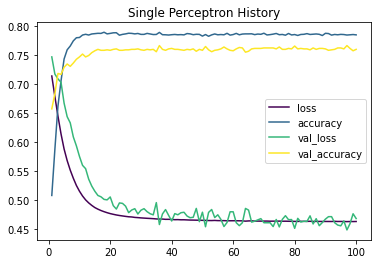

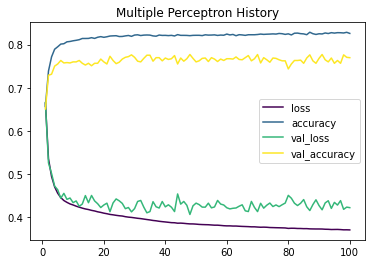

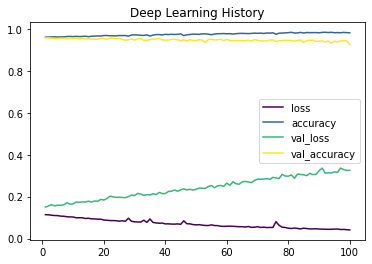

In [114]:
nn_history_plot = nn_history_df.plot(title = "Single Perceptron History",colormap= "viridis")
multi_history_plotf = multi_history_df.plot(title = "Multiple Perceptron History",colormap= "viridis")
deep_history_plot = deep_history_df.plot(title = "Deep Learning History",colormap= "viridis")

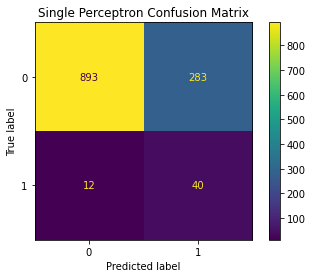

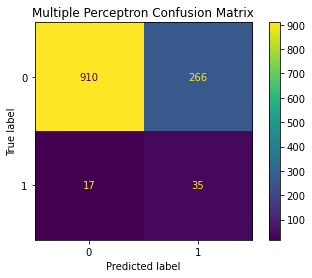

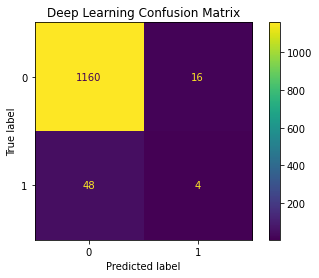

In [53]:
# Single Perceptron Confusion Matrix
nn_disp.plot()
nn_disp.ax_.set_title("Single Perceptron Confusion Matrix")

# Multiple Perceptron Confusion Matrix
multi_disp.plot()
multi_disp.ax_.set_title("Multiple Perceptron Confusion Matrix")

# Deep Learning Confusion Matrix
dl_disp.plot()
dl_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_disp

In [54]:
# Total Advanced Classification Metrics DF
total_acm = ({"Model Type": "Single Perceptron", "Accuracy":nn_accuracy_score, "Recall": nn_recall_score, "Specificity":nn_specificity_score, 
          "Balanced Accuracy": nn_bas, "Precision":nn_precision_score, "F1 Score":nn_f1_score, "Loss": nn_model_loss }, {"Model Type": "Multi Perceptron", "Accuracy":multi_accuracy_score, "Recall": multi_recall_score, "Specificity":multi_specificity_score, 
          "Balanced Accuracy": multi_bas, "Precision":multi_precision_score, "F1 Score":multi_f1_score, "Loss": multi_model_loss}, {"Model Type": "Deep Learning", "Accuracy":dl_accuracy_score, "Recall": dl_recall_score, "Specificity":dl_specificity_score, 
          "Balanced Accuracy": dl_bas, "Precision":dl_precision_score, "F1 Score":dl_f1_score, "Loss": dl_model_loss})
total_acm_df = pd.DataFrame(data=total_acm)
total_acm_df

,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.759772,0.769231,0.769231,0.764292,0.123839,0.213333,0.468126
1,Multi Perceptron,0.769544,0.673077,0.673077,0.723443,0.116279,0.198300,0.421914
2,Deep Learning,0.947883,0.076923,0.076923,0.531659,0.200000,0.111111,0.305371


In [48]:
# Model with the best 